# PEC Monte Carlo simulation

Start by importing MagmaPEC and MagmaPandas and any other packages you want to use. Here we also import Pandas for importing pressure data. For details on the use of MagmaPandas, please see it's [documentation](https://magmapandas.readthedocs.io/en/latest/).

In [1]:
import MagmaPEC as mpc
import MagmaPandas as mp

import pandas as pd

Confirm the model and PEC configurations. If you want to change models or PEC settings, follow the [configuration example](https://magmapec.readthedocs.io/en/latest/notebooks/config.html).

In [2]:
print(mpc.model_configuration)
print(mpc.PEC_configuration)


################## MagmaPandas ###################
##################################################
General settings__________________________________
fO2 buffer.....................................QFM
ΔfO2.............................................1
Melt Fe3+/Fe2+.............................sun2024
Kd Fe-Mg ol-melt........................toplis2005
Melt thermometer....................putirka2008_15
Volatile solubility model.......iaconomarziano2012
Volatile species.............................mixed
##################################################


############ Post-entrapment crystallisation ############
################### correction model ####################
Settings_________________________________________________
Fe2+ behaviour...................................buffered
Stepsize equilibration (moles)...................0.002   
Stepsize crystallisation (moles).................0.05    
Decrease factor..................................5       
FeO convergence (wt. %).......

In the next few steps we import all relevant data and set up the melt initial FeO prediction model. These steps are identical to the [FeOi](https://magmapec.readthedocs.io/en/latest/notebooks/FeOi.html#) and [PEC correction](https://magmapec.readthedocs.io/en/latest/notebooks/pec_corr.html#) examples

Import melt inclusion and olivine data:

In [3]:
melt_file = "./data/melt.csv"
olivine_file = "./data/olivine.csv"

melt = mp.read_melt(melt_file, index_col=["name"])
olivine = mp.read_olivine(olivine_file, index_col=["name"])

Import inclusion internal pressures or calculate them if you have measured melt CO2 (and H2O). See the [PEC model example](https://magmapec.readthedocs.io/en/latest/notebooks/pec_corr.html) for details on how to do the calculation. Here we import them from a file.

In [4]:
pressure_file ="./data/pressure.csv"
pressure = pd.read_csv(pressure_file, index_col = ["name"]).squeeze()

Set up the melt initial FeO prediction model:

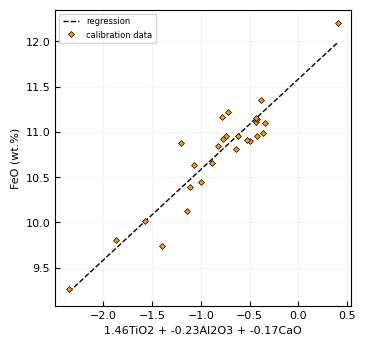

In [5]:
wholerock_file = "./data/wholerock.csv"
wholerock = mp.read_melt(wholerock_file, index_col=["name"])

x = wholerock.drop(columns=["FeO"])
FeOi_predict = mpc.FeOi_prediction(x=x, FeO=wholerock["FeO"])

do_not_use = ["MnO", "P2O5", "Cr2O3", "total"]

model_fits = FeOi_predict.calculate_model_fits(exclude=do_not_use)
FeOi_predict.select_predictors(idx=3)

Next, we need to set up the object that handles the random sampling of errors in the Monte Carlo simulation. This is done with the `PEC_MC_parameters` class and it includes the following parameters for error propagation:

- `melt_errors`
        
    propagate errors on melt composition by providing one standard deviation errors per element as a pandas Series (fixed errors for all inclusions) or DataFrame (errors per inclusion).

- `olivine_errors`

    propagate errors on olivine composition by providing one standard deviation errors per element as a pandas Series (fixed errors for all inclusions) or DataFrame (errors per inclusion).

- `pressure_errors`

    propagate errors on inclusion internal pressures by providing one standard deviations arrors as float or ints (fixed errors for all inclusions), or pandas series or numpy arrays (errors per inclusion).

- `FeOi_errors`

    propagate errors on estimate melt initial FeO contents. Fixed errors can be provided either for the whole dataset, or per inclusion. Alternatively, an [FeOi_prediction object](https://magmapec.readthedocs.io/en/latest/notebooks/FeOi.html) can be provided to propagate errors on predictions models.

- `Fe3Fe2`

    Propagate errors on modelled melt Fe<sup>2+</sup>/Fe<sup>3+</sup> ratios. Errors are automatically calculated by MagmaPandas based on the selected model. Pass *True* to this parameter to activate it.

- `Kd`

    Propagate errors on modelled olivine-melt Fe-Mg partition coefficients. Errors are automatically calculated by MagmaPandas based on the selected model. Pass *True* to this parameter to activate it.

By default errors are not propagated - you explicitely need to tell MagmaPEC to do so when initialising the `PEC_MC_parameters` object

In this example we will use all error propagation options, which means we need to provide melt and olivine composition errors. We import these from .csv files containing error data for individual inclusions and olivines. This is just an example with randomly generated errors, normally you should use analytical errors.

In [6]:
melt_errors_file = "./data/melt_errors.csv"
olivine_errors_file = "./data/olivine_errors.csv"

melt_errors = pd.read_csv(melt_errors_file, index_col=[0])
olivine_errors = pd.read_csv(olivine_errors_file, index_col=[0])

Make very sure that the elements in the error data have identical sorting to the melt and olivine dataframes, otherwise errors will be applied to the wrong elements. 
We can force this by sorting the columns of the error dataframes (or series) with the *elements* attributes of the melt and olivine MagmaFrames:

In [7]:
melt_errors = melt_errors[melt.elements]
olivine_errors = olivine_errors[olivine.elements]

Here's what they look like:

In [8]:
melt_errors.head()

,SiO2,Al2O3,MgO,CaO,FeO,Na2O,K2O,MnO,TiO2,P2O5,Cr2O3,CO2,H2O,F,S,Cl
PI032-04-01,1.02,0.64,0.14,0.47,0.69,0.10,0.08,0.05,0.18,0.05,0.05,0.17,0.21,0.22,0.10,0.12
PI032-04-02,1.06,0.84,0.29,0.46,0.54,0.05,0.03,0.01,0.06,0.18,0.04,0.24,0.12,0.13,0.12,0.04
PI041-02-02,1.04,0.90,0.09,0.55,0.49,0.22,0.21,0.01,0.16,0.04,0.00,0.15,0.23,0.04,0.17,0.06
PI041-03-01,0.98,0.64,0.10,0.40,0.53,0.12,0.12,0.08,0.01,0.03,0.00,0.05,0.36,0.06,0.14,0.04
PI041-03-03,1.02,0.54,0.31,0.42,0.68,0.18,0.03,0.02,0.11,0.06,0.10,0.18,0.08,0.13,0.06,0.15


In [9]:
olivine_errors.head()

,SiO2,FeO,MgO,NiO,MnO,Al2O3,CaO
PI032-04-01,1.06,0.60,1.22,0.01,0.09,0.08,0.02
PI032-04-02,0.85,0.57,1.28,0.14,0.07,0.24,0.06
PI041-02-02,1.11,0.44,1.30,0.08,0.10,0.01,0.19
PI041-03-01,0.99,0.50,1.31,0.14,0.16,0.15,0.01
PI041-03-03,0.95,0.64,1.21,0.13,0.11,0.10,0.15


Together with the `FeOi_prediction` object, we pass these as arguments to the `PEC_MC_parameters` object. Errors on pressure are fixed at 2 kbar for al inclusions via the *pressure_errors* argument. We also set *Fe3Fe2* and *Kd* to *True* in order to propagate their model errors.

In [10]:
mc_parameters = mpc.PEC_MC_parameters(melt_errors=melt_errors, olivine_errors=olivine_errors, pressure_errors=2e3, FeOi_errors=FeOi_predict, Fe3Fe2=True, Kd=True, temperature=True)

Now we can create the Monte Carlo model with the `PEC_MC` object

In [11]:
pec_mc_model = mpc.PEC_MC(inclusions=melt, olivines=olivine, P_bar=pressure, FeO_target=FeOi_predict, MC_parameters=mc_parameters)

and run it with 20 iterations:

In [12]:
pec_mc_model.run(n=20)

Monte Carlo iterations... |█████████████████████████| 100% [20/20] in 1:11.8 


Results are stored internally in the following attributes:

- `pec`: pandas DataFrame

    Average PEC extents (%) of the MC model and their one standard deviation errors. Positive values indicate post-entrapment crystallisation and negative melting.

- `inclusions_corr`: MagmaPandas Melt frame

    Averages of corrected melt inclusion compositions (wt. %)

- `inclusions_stddev`: pandas DataFrame

    One standard deviation errors on inclusions_corr (wt. %)

- `pec_MC`: pandas DataFrame

    PEC extents for individual iterations. Positive values indicate post-entrapment crystallisation and negative melting.

- `inclusions_MC`: dictionary of MagmaPandas Melt frames

    corrected melt inclusion compositions for individual iterations.
- `MC_inputs`: numpy array of dictionaries

    input parameters for each MC iteration. Each dictionary contains 
    - 'inclusions'
    - 'olivines'
    - 'P_bar'
    - 'FeO_target' 
    - 'Fe3Fe2_offset_parameters'
    - 'Kd_offset_parameters'
    - 'temperature_offset_parameters'

    if you want to view the parameters used for iteration _n_, use `pec_mc_model.MC_inputs[n]`, and if you want to run this iteration individually use `mpc.PEC(**pec_mc_model.MC_inputs[n])`

In [13]:
pec = pec_mc_model.pec
inclusions_corrected = pec_mc_model.inclusions_corr
inclusions_errors = pec_mc_model.inclusions_stddev

pec_mc = pec_mc_model.pec_MC
inclusions_MC = pec_mc_model.inclusions_MC

In [14]:
pec

,pec,stddev
name,,
PI032-04-01,9.685277,5.443236
PI032-04-02,10.868720,4.281761
PI041-02-02,0.368495,2.965795
PI041-03-01,13.524623,5.176464
PI041-03-03,13.087550,5.469071
PI041-05-04,-3.841895,2.874289
PI041-05-06,2.573486,3.331781
PI041-07-01,12.885425,4.738129
PI041-07-02,11.996061,4.764667


In [15]:
inclusions_corrected

,SiO2,Al2O3,MgO,CaO,FeO,Na2O,K2O,MnO,TiO2,P2O5,Cr2O3,CO2,H2O,F,S,Cl
name,,,,,,,,,,,,,,,,
PI032-04-01,48.854736,13.989939,7.733251,9.756356,10.272426,3.552850,0.664288,0.140531,2.384549,0.270005,0.000000,0.620748,1.373265,0.137289,0.165366,0.084401
PI032-04-02,47.938471,14.985039,7.510094,9.545912,10.322534,3.452154,0.914013,0.139713,2.567965,0.352508,0.000000,0.677713,1.309715,0.081084,0.154427,0.048657
PI041-02-02,49.102677,16.951397,4.883078,9.425064,10.127767,3.736871,1.023089,0.155205,2.779284,0.552344,0.000000,0.441630,0.614232,0.053783,0.099636,0.053943
PI041-03-01,45.917138,15.675827,7.424108,10.806755,10.672145,3.245829,1.120739,0.118133,3.104618,0.539431,0.000000,0.799663,0.366641,0.094553,0.056260,0.058159
PI041-03-03,45.444744,15.606286,7.196503,11.095448,10.862131,3.357512,1.163975,0.086978,3.245260,0.512273,0.000000,0.822170,0.301381,0.127218,0.067515,0.110604
PI041-05-04,47.877579,18.671661,3.779860,9.457522,9.299051,4.630310,1.636540,0.162759,2.499504,0.824601,0.000000,0.403848,0.484387,0.093956,0.123563,0.054859
PI041-05-06,46.385388,16.810662,4.821381,8.860490,11.524027,4.197472,1.368307,0.128971,3.658201,0.629224,0.000000,0.616049,0.674135,0.128050,0.124094,0.073549
PI041-07-01,45.961815,14.860880,7.425545,9.578621,11.691891,3.113103,1.265879,0.167545,3.521256,0.547985,0.000000,0.467122,1.005410,0.122266,0.175441,0.095240
PI041-07-02,45.941338,15.589071,7.036013,9.952622,11.427614,3.166068,1.355262,0.139580,3.501012,0.611335,0.000000,0.360888,0.657041,0.072969,0.126636,0.062551


In [16]:
inclusions_errors

,SiO2_stddev,Al2O3_stddev,MgO_stddev,CaO_stddev,FeO_stddev,Na2O_stddev,K2O_stddev,MnO_stddev,TiO2_stddev,P2O5_stddev,Cr2O3_stddev,CO2_stddev,H2O_stddev,F_stddev,S_stddev,Cl_stddev
name,,,,,,,,,,,,,,,,
PI032-04-01,0.686030,0.922066,1.492955,0.573610,0.331683,0.188475,0.083719,0.053939,0.140933,0.038465,0.000000,0.161533,0.249122,0.140233,0.101547,0.069214
PI032-04-02,0.556864,0.721940,1.273484,0.422099,0.261176,0.150692,0.050106,0.013296,0.135044,0.144859,0.000000,0.198639,0.095009,0.076590,0.114092,0.036706
PI041-02-02,0.657886,0.904655,0.926579,0.589270,0.348315,0.206251,0.240745,0.012601,0.176104,0.035135,0.000000,0.175957,0.184304,0.037234,0.120262,0.059369
PI041-03-01,0.607437,0.767089,1.550640,0.491581,0.216898,0.139260,0.111988,0.062756,0.117192,0.032272,0.000000,0.059690,0.256321,0.055374,0.062444,0.030225
PI041-03-03,0.702875,0.763589,1.625072,0.640912,0.260789,0.193349,0.043944,0.021875,0.157445,0.072849,0.000000,0.185321,0.056151,0.123519,0.043792,0.114647
PI041-05-04,0.672830,1.168031,0.848682,0.439815,0.400744,0.242245,0.091677,0.109928,0.077135,0.025504,0.000000,0.206050,0.107820,0.100505,0.008768,0.008581
PI041-05-06,0.732337,1.212365,0.993845,0.418659,0.414983,0.338946,0.253796,0.150857,0.183679,0.049370,0.000000,0.263663,0.288044,0.115429,0.064589,0.026683
PI041-07-01,0.737342,1.272026,1.394157,0.487066,0.269609,0.141461,0.052296,0.061435,0.153585,0.027910,0.000000,0.036235,0.157321,0.091054,0.027396,0.131493
PI041-07-02,0.507348,0.808809,1.353831,0.475640,0.210996,0.149289,0.142977,0.053007,0.138495,0.024398,0.000000,0.208935,0.208426,0.003121,0.036500,0.061395


In [17]:
pec_mc.head()

name,PI032-04-01,PI032-04-02,PI041-02-02,PI041-03-01,PI041-03-03,PI041-05-04,PI041-05-06,PI041-07-01,PI041-07-02,PI052-01-02
iteration,,,,,,,,,,
0,11.463013,10.868896,2.152051,13.980615,9.322839,-3.415686,0.61897,16.520557,10.301697,-6.992139
1,11.035217,13.332764,0.00022,11.846985,15.287744,-4.388879,0.839026,11.163055,11.717395,-7.155634
2,2.819513,4.801294,-3.265625,7.811121,11.339624,-6.0,-1.0,7.610901,11.0,-7.909094
3,17.419189,11.357178,0.6,16.873785,14.450586,-3.647949,1.817664,13.938098,12.245459,-6.078774
4,0.0,5.996069,-4.714355,7.635742,7.634424,-8.244373,-3.002954,5.939392,7.183643,-12.570471


The dataframes in `inclusions_MC` also have *isothermal_equilibration*, *Kd_equilibration*, and *FeO_converge* columns. These columns show if equilibrations during stage [1] and [2] and FeO convergence in stage [2] were successful. Extreme cases of random error sampling may yield melt-olivine pairs that cannot be equilibrated without requiring crystallising exceeding the mass of the inclusion inclusion or exchange of more Mg or Fe than the inclusion contains. If that is the case, no corrected compositions are calculated and the isothermal- of Kd-equilibration column is set to *False*.

In [18]:
inclusions_MC["PI032-04-01"].head()

,SiO2,Al2O3,MgO,CaO,FeO,Na2O,K2O,MnO,TiO2,P2O5,Cr2O3,CO2,H2O,F,S,Cl,isothermal_equilibration,Kd_equilibration,FeO_converge
iteration,,,,,,,,,,,,,,,,,,,
0,48.320687,13.731066,7.961831,10.608291,10.297861,3.435463,0.56264,0.185908,2.480271,0.274358,0.0,0.551662,1.013808,0.449679,0.126475,0.0,True,True,True
1,48.902367,13.723224,8.375555,9.465865,10.452848,3.661973,0.593371,0.163055,2.437956,0.306267,0.0,0.41602,1.20149,0.0,0.123661,0.176348,True,True,True
2,49.122495,14.468462,5.966062,10.059649,10.030713,3.790503,0.72159,0.188032,2.282057,0.351395,0.0,1.055721,1.5671,0.0,0.373656,0.022564,True,True,True
3,49.086461,12.777884,9.179393,9.033345,10.43309,3.281305,0.654525,0.217169,2.252173,0.252045,0.0,0.794818,1.801323,0.0,0.150781,0.085688,True,True,True
4,49.570999,15.327817,5.503705,9.958353,9.94887,4.041957,0.894194,0.071748,2.374253,0.246788,0.0,0.463712,1.151632,0.125379,0.166631,0.153963,True,<NA>,True


Lets view the pressures used for different iterations:

In [23]:
pec_mc_model.MC_inputs[1]["P_bar"], pec_mc_model.MC_inputs[4]["P_bar"]

(name
 PI032-04-01    2820.134038
 PI032-04-02    2947.689858
 PI041-02-02     671.967541
 PI041-03-01    2264.566801
 PI041-03-03    2216.237876
 PI041-05-04     101.998027
 PI041-05-06    1227.736645
 PI041-07-01    2384.084584
 PI041-07-02    1164.839501
 PI052-01-02     119.941865
 Name: IaconoMarziano, dtype: float64,
 name
 PI032-04-01    4659.725542
 PI032-04-02    4787.281361
 PI041-02-02    2511.559044
 PI041-03-01    4104.158304
 PI041-03-03    4055.829380
 PI041-05-04    1941.589530
 PI041-05-06    3067.328149
 PI041-07-01    4223.676087
 PI041-07-02    3004.431004
 PI052-01-02    1959.533368
 Name: IaconoMarziano, dtype: float64)